In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from utils import *

import warnings
warnings.filterwarnings("ignore")

# Deshabilitar el modo interactivo
plt.ioff()

pd.set_option('display.max_columns', 500)

## Parametros

In [2]:
table = 'Diabetes_avicena_survival.diabetes_final_3_annos'

variables_with_outliers = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal']

numeric_columns = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal','time_to_event']
categoric_columns = ['genero_paciente','raza_paciente','nivel_academico_paciente','ant_cardio','med_hipertension','ant_familiar_dm','hace_ejercicio']
target = 'diabetes'

variables_base = ['edad','IMC','HDL','LDL','trigliceridos','genero_paciente']

## Carga de datos

In [3]:
data = client_bq.query(f'SELECT * FROM {table}').result().to_dataframe()
print(f'Se trajo {data.shape} datos de pacientes')
data.head()

Se trajo (735003, 21) datos de pacientes


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,1003390652,2022,2,2022-02-01,26,105.233333,1.60,41.106770833,71.20,106.14,117.80,111.0,Femenino,Mestizo,Bachillerato técnico,0,0,0,None,0,34
1,1006578626,2022,2,2022-02-01,20,68.700000,1.77,21.928564589,56.25,143.00,100.05,NaN,Masculino,Otros,Profesional,1,0,0,None,0,36
2,1007218577,2022,2,2022-02-01,28,74.300000,1.78,23.450321929,45.10,96.64,64.68,NaN,Masculino,Otros,Ninguno,0,0,0,None,0,33
3,1010021506,2022,2,2022-02-01,36,71.000000,1.60,27.734375000,60.00,140.00,117.00,NaN,Masculino,Otros,Tecnológica,1,1,0,None,0,35
4,10241950,2022,2,2022-02-01,67,85.800000,1.72,29.002163332,41.00,82.00,203.00,105.0,Masculino,Otros,Básica secundaria,1,1,0,None,1,13


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735003 entries, 0 to 735002
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   numero_identificacion_paciente  735003 non-null  object 
 1   year                            735003 non-null  Int64  
 2   month                           735003 non-null  Int64  
 3   fecha                           735003 non-null  dbdate 
 4   edad                            735003 non-null  Int64  
 5   peso                            735003 non-null  float64
 6   talla                           735003 non-null  float64
 7   IMC                             735003 non-null  object 
 8   HDL                             735003 non-null  float64
 9   LDL                             735003 non-null  float64
 10  trigliceridos                   735003 non-null  float64
 11  perimetro_abdominal             319193 non-null  float64
 12  genero_paciente 

In [5]:
# Seleccion de variables linea base

df_base = data[variables_base + ['time_to_event','diabetes']]

df_base

,edad,IMC,HDL,LDL,trigliceridos,genero_paciente,time_to_event,diabetes
0,26,41.106770833,71.20,106.14,117.80,Femenino,34,0
1,20,21.928564589,56.25,143.00,100.05,Masculino,36,0
2,28,23.450321929,45.10,96.64,64.68,Masculino,33,0
3,36,27.734375000,60.00,140.00,117.00,Masculino,35,0
4,67,29.002163332,41.00,82.00,203.00,Masculino,13,1
...,...,...,...,...,...,...,...,...
734998,52,33.962396275,30.00,116.00,275.00,Masculino,21,1
734999,76,22.656250000,47.90,65.62,92.40,Masculino,35,1
735000,70,22.837370242,42.00,58.00,183.00,Masculino,35,1
735001,82,29.014650962,39.00,154.00,177.00,Masculino,1,0


In [6]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735003 entries, 0 to 735002
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   edad             735003 non-null  Int64  
 1   IMC              735003 non-null  object 
 2   HDL              735003 non-null  float64
 3   LDL              735003 non-null  float64
 4   trigliceridos    735003 non-null  float64
 5   genero_paciente  735003 non-null  object 
 6   time_to_event    735003 non-null  Int64  
 7   diabetes         735003 non-null  Int64  
dtypes: Int64(3), float64(3), object(2)
memory usage: 47.0+ MB


In [7]:
df_base.describe()

,edad,HDL,LDL,trigliceridos,time_to_event,diabetes
count,735003.0,735003.000000,735003.000000,735003.000000,735003.0,735003.0
mean,55.246026,48.339312,117.673353,157.202521,17.497995,0.203388
std,15.920614,36.445320,77.459818,803.760089,10.348544,0.402519
min,18.0,0.000000,-113.860000,0.000000,1.0,0.0
25%,44.0,39.000000,89.600000,96.800000,8.0,0.0
50%,56.0,46.300000,115.000000,133.000000,18.0,0.0
75%,67.0,55.000000,142.000000,186.000000,27.0,0.0
max,111.0,22545.780000,34159.000000,386000.000000,36.0,1.0


In [8]:
df_base_no_outliers = take_out_outliers(df_base, variables_base[:-1], verbose = False)

print(f'Cantidad de afiliados sin outliers {df_base_no_outliers.shape}')

Cantidad de afiliados sin outliers (660085, 8)


In [9]:
df_base_no_outliers.describe()

,edad,IMC,HDL,LDL,trigliceridos,time_to_event,diabetes
count,660085.000000,660085.000000,660085.000000,660085.000000,660085.000000,660085.0,660085.0
mean,55.438397,27.460112,47.757635,116.382882,141.448141,17.575436,0.200308
std,16.019130,4.327374,11.036310,37.320618,60.138678,10.347731,0.400231
min,18.000000,15.447846,15.000000,11.000000,0.000000,1.0,0.0
25%,44.000000,24.414062,39.900000,90.000000,96.000000,8.0,0.0
50%,56.000000,27.110583,46.800000,115.000000,130.000000,18.0,0.0
75%,67.000000,30.218890,54.800000,141.320000,177.000000,27.0,0.0
max,101.000000,39.496876,79.000000,220.600000,319.800000,36.0,1.0


In [10]:
df_base_no_outliers

,edad,IMC,HDL,LDL,trigliceridos,genero_paciente,time_to_event,diabetes
1,20.0,21.928565,56.25,143.00,100.05,Masculino,36,0
2,28.0,23.450322,45.10,96.64,64.68,Masculino,33,0
3,36.0,27.734375,60.00,140.00,117.00,Masculino,35,0
4,67.0,29.002163,41.00,82.00,203.00,Masculino,13,1
5,66.0,25.780774,46.50,46.30,109.00,Masculino,1,1
...,...,...,...,...,...,...,...,...
734998,52.0,33.962396,30.00,116.00,275.00,Masculino,21,1
734999,76.0,22.656250,47.90,65.62,92.40,Masculino,35,1
735000,70.0,22.837370,42.00,58.00,183.00,Masculino,35,1
735001,82.0,29.014651,39.00,154.00,177.00,Masculino,1,0


## Graficos contra diabetes

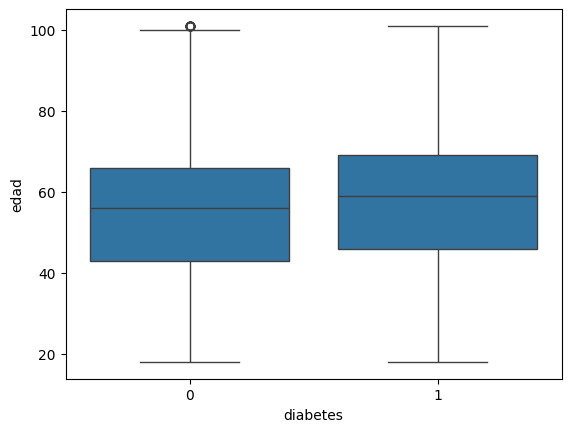

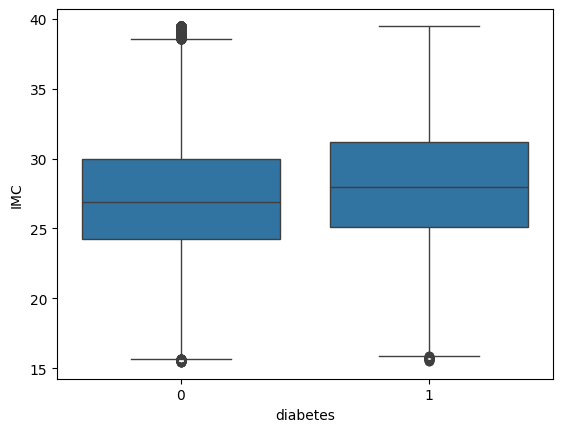

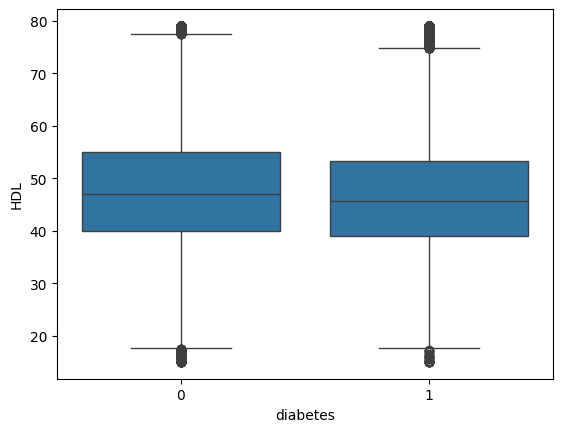

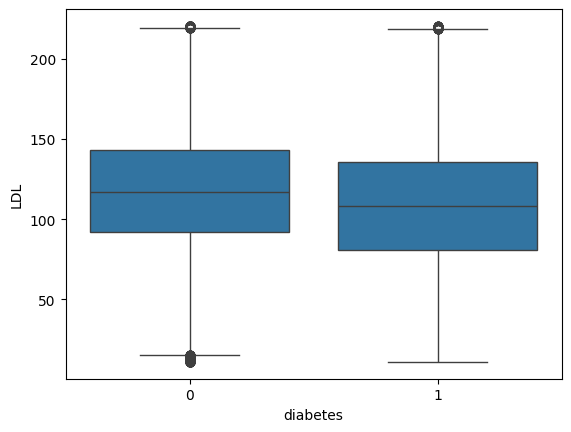

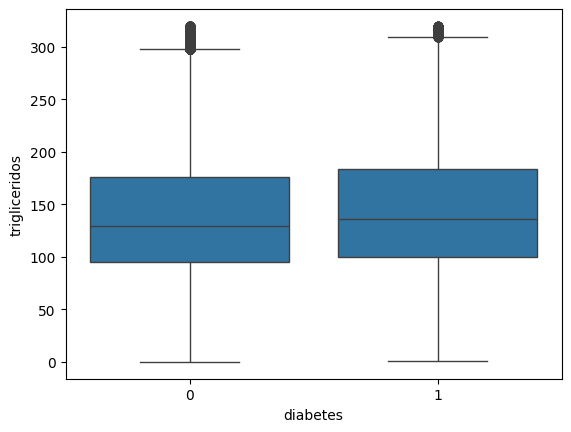

In [11]:
for column in variables_base[:-1]:
    sns.boxplot(df_base_no_outliers, y = column, x = 'diabetes')
    plt.show()

,genero_paciente,diabetes,Conteo
0,Femenino,0,326133
1,Femenino,1,83583
2,Masculino,0,201732
3,Masculino,1,48637


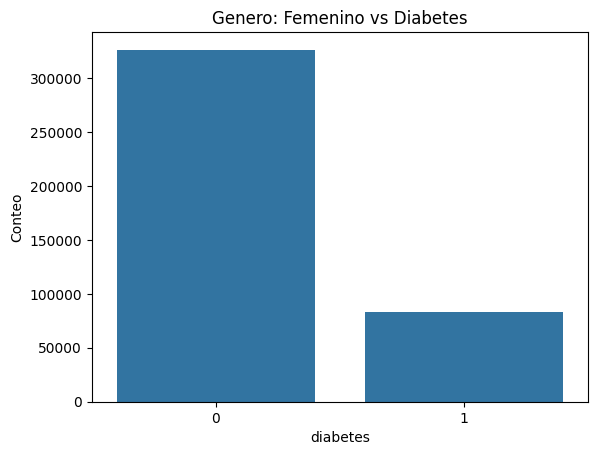

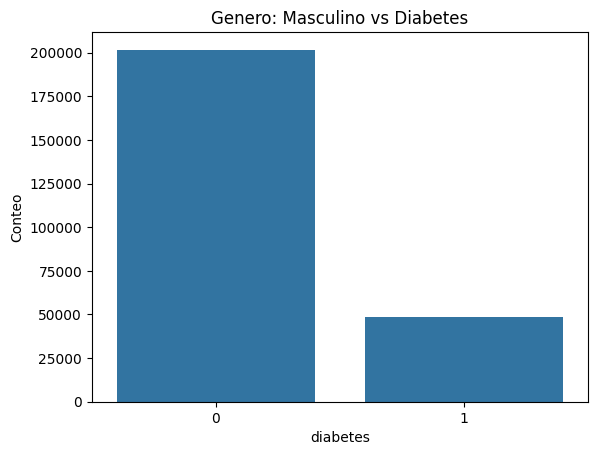

In [12]:
df_to_plot = df_base_no_outliers[['edad','genero_paciente','diabetes']].astype(str)
df_to_plot = df_to_plot.groupby(['genero_paciente','diabetes'], as_index = False).count()
df_to_plot.rename(columns = {'edad': 'Conteo'}, inplace = True)
display(df_to_plot)

for genero in ['Femenino','Masculino']:
    sns.barplot(df_to_plot[df_to_plot.genero_paciente == genero], x = 'diabetes', y = 'Conteo').set_title(f'Genero: {genero} vs Diabetes')
    plt.show()

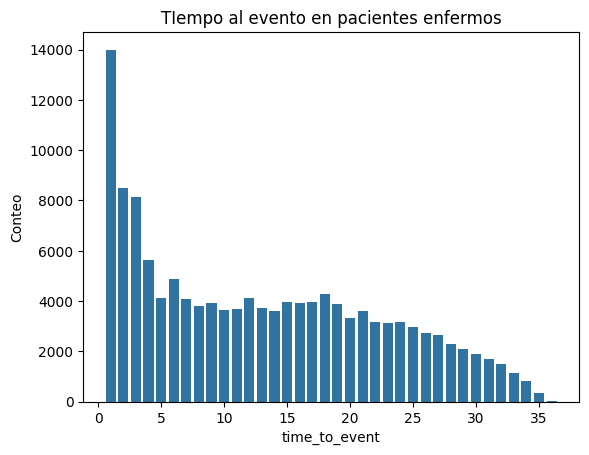

In [13]:
# Tiempo al evento en pacientes enfermos

df_enfermos = df_base_no_outliers[df_base_no_outliers.diabetes == 1][['time_to_event','diabetes','edad']]#.astype(str)

df_to_plot = df_enfermos.groupby(['time_to_event','diabetes'], as_index = False).count().sort_values('time_to_event').rename(columns = {'edad': 'Conteo'})

sns.barplot(df_to_plot, x = 'time_to_event', y = 'Conteo',native_scale=True).set_title(f'TIempo al evento en pacientes enfermos')
plt.show()

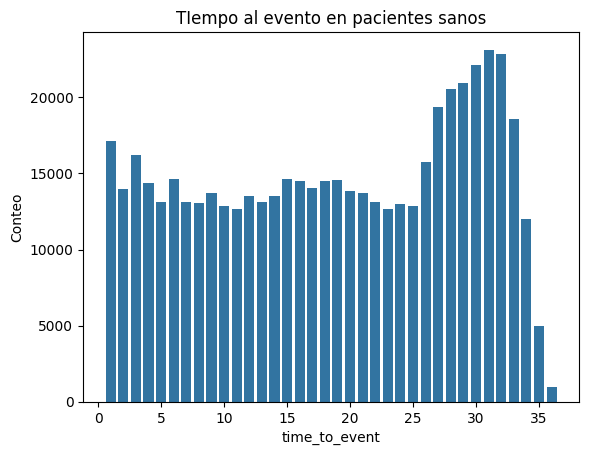

In [14]:
# Tiempo al evento en pacientes enfermos

df_enfermos = df_base_no_outliers[df_base_no_outliers.diabetes == 0][['time_to_event','diabetes','edad']]#.astype(str)

df_to_plot = df_enfermos.groupby(['time_to_event','diabetes'], as_index = False).count().sort_values('time_to_event').rename(columns = {'edad': 'Conteo'})

sns.barplot(df_to_plot, x = 'time_to_event', y = 'Conteo',native_scale=True).set_title(f'TIempo al evento en pacientes sanos')
plt.show()